### Overview
This code aims to apply a pre-trained model to a larger ocean region. 
- The model only accepts 48x48 pixel images. Thus, we must split the larger input image into 48x48 sub-grids, apply the model, then re-stitch these results back together. 
- However, if the sub-grids were selected without overlap, a disparity will occur at the border between two sub-grids after re-stitching since the model will act differently on each sub-grid.
- Thus, the approach is instead to create overlapping sub-grids and subsequently blend the results together (more on this below). 
- The default model is trained in the gradient domain. Consequently, we must re-construct the gradient outputs back into the absolute SST domain. This makes use of the `reconstruction` code. 
- Additionally, we take the SST outputs into frequency space via the power spectrum. This allows us to compare the spatial structure of the images. The gradient restored image should have a higher amplitude of high frequency components. 
- Ideally, we want to compare the power spectra of (1) the original L4, (2) the ground truth gradient restored and (3) the model-predicted gradient restored. However, it is difficult to extract a gradient-restored image over larger regions. There is no issue with extracting large L4 images, provided there are no land masses in the image. So, if you do not have the ground truth data, comment out the associated plots in the final cell, and just work with the L4 and model prediction.

**Note:** As of 14/08/2024, there is a major issue occurring on the image borders during the blending process. This is due to a flaw in the blending algorithm at the border grids. The current remedy is to crop out the border values. For smaller images (e.g. 150x150), this results in the majority of the image being cropped. It is therefore better to use much larger images.

### Import and Load data

In [123]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.signal import windows
import torch
import torch.nn as nn
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

In [139]:
ds = xr.open_dataset("lustre_scratch/data/regions/150x150_1.nc")

### Define power spectrum and absolute reconstruction.
These functions are to be used *after* applying the model prediction.
1. `power_spec`: The power spectrum is the frequency-space representation of the image. First, the 2D Fourier transform is taken. This is flattened into 1D, along with the frequency-space norms of the wavenumbers ($k$). Wavenumber is proportional to the inverse of wavelength, and thus a high $k$ indicates high spatial frequency. The goal is for the model to increase the occurrence of high frequency components in the image, as this is an indicator of sharper gradients. 
2. `absolute_reconstruction`: this is taken from the `absolute_reconstruction` notebook. We use the sparse matrix representation here, as this is a $\mathcal{O}(N)$ operation. The non-sparse (more readable) approach is $\mathcal{O}(N^2)$ and is thus computationally inefficient for our larger images.

In [132]:
def power_spec(image):    
    npix = image.shape[0]

    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    kfreq = np.fft.fftfreq(npix) * npix
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                         statistic = "mean",
                                         bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

def absolute_reconstruction(G_x, G_y, l4): 
    ## Re-construct absolute domain from x and y gradient channels
    ## Requires the low-res L4 image as a reference
    
    dim = G_x.shape[0] # dim x dim image
    N = dim**2
    
    # grad_x sparse matrix operator
    grad_x_data = []
    grad_x_row_indices = []
    grad_x_col_indices = []
    for i in range(N):
        if (i+1) % dim != 0:
            grad_x_data.extend([-1, 1])
            grad_x_row_indices.extend([i, i])
            grad_x_col_indices.extend([i, i+1])
    
    grad_x = sp.csr_matrix((grad_x_data, (grad_x_row_indices, grad_x_col_indices)), shape=(N, N))
    
    # grad_y sparse matrix operator
    grad_y_data = []
    grad_y_row_indices = []
    grad_y_col_indices = []
    for i in range(N):
        if (i+1) // (N-(dim-1)) == 0: 
            grad_y_data.extend([-1, 1])
            grad_y_row_indices.extend([i, i])
            grad_y_col_indices.extend([i, i+dim])
    
    grad_y = sp.csr_matrix((grad_y_data, (grad_y_row_indices, grad_y_col_indices)), shape=(N, N))
    
    # now we set-up the equation Ax = b using sparse matrices
    A = grad_x.transpose().dot(grad_x) + grad_y.transpose().dot(grad_y)
    
    G_x_vec = np.ndarray.flatten(G_x)
    G_y_vec = np.ndarray.flatten(G_y)
    b = grad_x.transpose().dot(G_x_vec) + grad_y.transpose().dot(G_y_vec)
    
    # solve system of linear equations using sparse solver
    solution = splinalg.spsolve(A, b)
    
    # re-shape flattened vector to (dim x dim) matrix
    reconstructed = np.reshape(solution, (dim, dim))
    
    # scale values
    l4_min, l4_max = np.min(l4), np.max(l4)
    recon_min, recon_max = np.min(reconstructed), np.max(reconstructed)
    normalized_recon = (reconstructed - recon_min) / (recon_max - recon_min)
    rescaled_reconstructed = normalized_recon * (l4_max - l4_min) + l4_min
    
    return rescaled_reconstructed


### Apply model to region via overlapping sub-grids
Process: 
1. Split the model into overlapping 48x48 sub-grids. As an example, consider an overlap of 12. This means that the next image begins at the 48-12=36th pixel of the current image. The best results are achieved by a high overlap variable (as close as possible to 47, although this takes much time). 
2. Apply the model to each sub-grid.
3. Blend the sub-grids together. To achieve this, a linear ramp is used: $f_i(x,y)\cdot g_i(x,y) + f_{i+1}(x,y)\cdot g_{i+1}(x,y)$ where $f$ is the linear ramp, ranging from 0 to 1: $f_i + f_{i+1}=1$, and $g$ is the model output. The goal of $f$ is to give more weighting to image $i$ further into image $i$, and less weighting further into the overlap. This is repeated in the x and y directions and upon reaching the final grid, no blending is done (possibly the source of the edge issue?!).

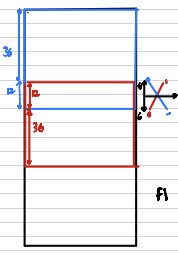

4. Stitch the images back together, by filling in an empty grid of the required dimensions.

In [133]:
def subgrid(image, split, overlap):
    # Calculate the number of subgrids along each dimension
    step = split - overlap
    N_grids_x = (image.shape[0] - overlap) // step
    N_grids_y = (image.shape[1] - overlap) // step
    subgridded = np.zeros((N_grids_x, N_grids_y, split, split))
    print(N_grids_x)
    for i in range(N_grids_x):
        for j in range(N_grids_y):
            start_x = i * step
            start_y = j * step
            subgridded[i, j] = image[start_x:start_x + split, start_y:start_y + split]
    return subgridded

def apply_model(model, gx, gy): 
    stacked = np.stack((gx, gy), axis = 0)
    subgrid_tensor = torch.from_numpy(stacked).to(device)
    return model(subgrid_tensor).detach().cpu().numpy()

def blend(im1, im2, overlap, direction = 'x'):
    ## blend im2 into im1
    im1_ramp = np.flip(np.linspace(0,1,overlap))
    im2_ramp = 1 - im1_ramp
    dim = im1.shape[0]
    start_index = dim - overlap - 1
    if direction == 'x': 
        for i in range(overlap): 
            im1[start_index+i] = im1[start_index+i]*im1_ramp[i] + im2[i]*im2_ramp[i]
    elif direction == 'y': 
        for j in range(overlap): 
            im1[:,start_index+j] = im1[:,start_index+j]*im1_ramp[j] + im2[:,j]*im2_ramp[j]
    else: 
        raise Exception("Direction must be x or y.")
    return im1 

def stitch(image_array, split, overlap): 
    ## image_array should be shape (N_grids_x, N_grids_y, split, split)
    N_grids_x, N_grids_y = image_array.shape[0], image_array.shape[1]
    step = split - overlap
    dim_x = step * (N_grids_x - 1) + split
    dim_y = step * (N_grids_y - 1) + split
    stitched_image = np.zeros((dim_x, dim_y))
    
    for i in range(N_grids_x):
        for j in range(N_grids_y):
            start_x = i * step
            start_y = j * step
            stitched_image[start_x:start_x+split, start_y:start_y+split] += image_array[i, j]

    return stitched_image


def model_prediction(grad_x, grad_y, model, split=48, overlap=12):
    ## wrap all functions
    # subgrid
    subgridded_gx, subgridded_gy = subgrid(grad_x, split, overlap), subgrid(grad_y, split, overlap)
    N_grids = subgridded_gx.shape[0]
    # apply model to subgrids
    gR = np.zeros((2,N_grids,N_grids,split,split)) # empty gR array
    for i in range(N_grids): 
        for j in range(N_grids): 
            gR[:,i,j] = apply_model(model, subgridded_gx[i,j], subgridded_gy[i,j])
    subgridded_gx_pred, subgridded_gy_pred = gR[0], gR[1]
    ## blend subgrids
    subgridded_gx_blend, subgridded_gy_blend = (np.zeros((N_grids, N_grids, split, split)) for _ in range(2))
    # blend in x-dir
    for j in range(N_grids):
        for i in range(N_grids): 
            if i!= N_grids-1:
                subgridded_gx_blend[i,j] = blend(subgridded_gx_pred[i,j], subgridded_gx_pred[i+1,j], overlap, direction = 'x')
                subgridded_gy_blend[i,j] = blend(subgridded_gy_pred[i,j], subgridded_gy_pred[i+1,j], overlap, direction = 'x')
            else:
                subgridded_gx_blend[i,j] = subgridded_gx_pred[i,j]
                subgridded_gy_blend[i,j] = subgridded_gy_pred[i,j,]
    #blend in y-dir
    for i in range(N_grids):
        for j in range(N_grids): 
            if j!= N_grids-1:
                subgridded_gx_blend[i,j] = blend(subgridded_gx_pred[i,j], subgridded_gx_pred[i,j+1], overlap, direction = 'y')
                subgridded_gy_blend[i,j] = blend(subgridded_gy_pred[i,j], subgridded_gy_pred[i,j+1], overlap, direction = 'y')
            else:
                subgridded_gx_blend[i,j] = subgridded_gx_pred[i,j]
                subgridded_gy_blend[i,j] = subgridded_gy_pred[i,j]
    gx_reconstructed, gy_reconstructed = stitch(subgridded_gx_blend, split, overlap), stitch(subgridded_gy_blend, split, overlap)
    return gx_reconstructed, gy_reconstructed 

### Load Model
It is necessary to copy the model class in here (not possible to import in Jupyter). The saved model file is simply the model parameters, which we must load into the model. 

In [134]:
class ERes_Block(nn.Module):
    # enhanced residual block
    def __init__(self, input_channels = 64):
        # define layers
        super(ERes_Block, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size = 3, stride = 1, padding = 'same')
        # must return same no. of channels as inputted
        self.conv2 = nn.Conv2d(64, input_channels, kernel_size = 3, stride = 1, padding = 'same')
        self.relu = nn.ReLU()
    def forward(self, x):
        x_skip = x # save for skip connection
        x = self.relu(self.conv1(x))
        x = self.conv2(x) * 0.1
        x = torch.add(x,x_skip) # add copy to x
        return x
        
class EDSR(nn.Module): 
    def __init__(self, input_channels = 1, output_channels = 1, N_blocks=16):
        # define layers
        super(EDSR, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size = 3, dilation=1, padding = 'same') # dilation=1
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size = 3, padding = 'same')
        self.erb = ERes_Block(64)
        self.N_blocks = N_blocks
        self.relu = nn.ReLU()
    def forward(self, x):
        x=x.float()
        x=self.relu(self.conv1(x))
        x_skip = x
        ## 16 residual blocks
        for _ in range(self.N_blocks):
            x = self.erb(x)
        x = self.relu(self.conv2(x))
        x = torch.add(x,x_skip)
        x = self.conv3(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = 'models/edsr_hp_search/EDSR_best_lr2.72e-05'
model = EDSR(2,2).to(device)
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

### Apply Code
- Find $x$ and $y$ gradients of L4 data and insert into `model_prediction` function. 
- Crop the images due to the edge bug.  
- Find the power spectrum of the L4, prediction and gRsst (if you have it). 

In [140]:
i = 0
L4_image = ds.sstL4.isel(i=i).data
gR_image = ds.gRsst.isel(i=i).data
ds['sst_gradx'] = ds.sstL4.differentiate('x')
ds['sst_grady'] = ds.sstL4.differentiate('y')
ds['gr_gradx'] = ds.gRsst.differentiate('x')
ds['gr_grady'] = ds.gRsst.differentiate('y')
sx, sy = ds.sst_gradx.isel(i=i).data, ds.sst_grady.isel(i=i).data
gR_grad_x = ds.gr_gradx.isel(i=i).data

overlap=47
gx, gy = model_prediction(sx, sy, model, overlap=overlap)
crop = overlap
gx = gx[crop:-crop, crop: -crop]
gy = gy[crop:-crop, crop: -crop]
sx = sx[crop:-crop, crop: -crop]
sy = sy[crop:-crop, crop: -crop]
L4_image = L4_image[crop:-crop, crop: -crop]
gR_image = gR_image[crop:-crop, crop: -crop]
gR_grad_x = gR_grad_x[crop:-crop, crop:-crop]


gR_pred = absolute_reconstruction(gx,gy,L4_image)

k_l4, A_l4 = power_spec(L4_image)
k_gR, A_gR = power_spec(gR_image)
k_gR_pred,A_gR_pred = power_spec(gR_pred)

103
103


#### 

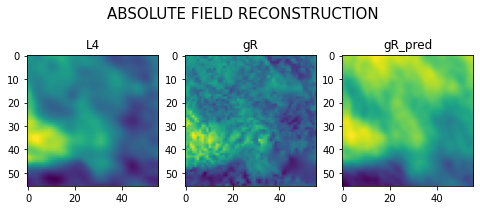

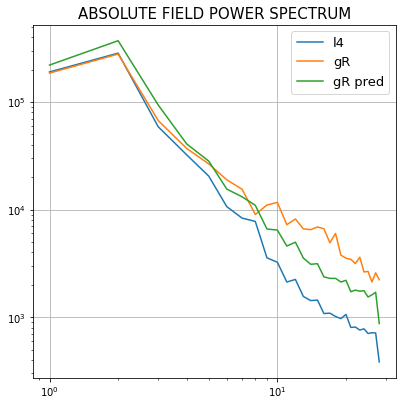

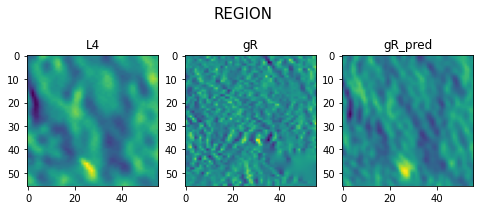

In [137]:
## Plotting
fig,ax=plt.subplots(1,3, figsize = (8,8))
fig.suptitle('ABSOLUTE FIELD RECONSTRUCTION', fontsize = 15, y= 0.7)
ax[0].imshow(L4_image)
ax[1].imshow(gR_image)
ax[2].imshow(gR_pred)
ax[0].set_title('L4')
ax[1].set_title('gR')
ax[2].set_title('gR_pred')
plt.show()


fig,ax=plt.subplots(figsize=(6.5,6.5))
ax.loglog(k_l4,A_l4, label='l4')
ax.loglog(k_gR,A_gR, label='gR')
ax.loglog(k_gR_pred,A_gR_pred, label='gR pred')
ax.legend(fontsize=13)
ax.set_title('ABSOLUTE FIELD POWER SPECTRUM', fontsize = 15)
ax.grid()
fig.show()

# #Find global min and max across all images
# global_min = min(sx.min(), gx.min())
# global_max = max(sx.max(), gx.max())

#Plotting with shared color scale

fig, ax = plt.subplots(1, 3, figsize=(8, 8))
lim_min, lim_max = 0, 45

fig.suptitle('REGION', fontsize = 15, y=0.7)
ax[0].imshow(sx)
ax[0].set_title('L4')
ax[1].imshow(gR_grad_x)
ax[1].set_title('gR')
ax[2].imshow(gx)
ax[2].set_title('gR_pred')

plt.show()